In [443]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib import colors as mcolors

import package_DBR
import student_package

from package_DBR import myRound, SelectPath_RT, Delay_RT, FO_RT, FOPDT, SOPDT, FOPDT_cost, SOPDT_cost, Process, Bode
from importlib import reload
student_package = reload(student_package)
from student_package import PID_RT, LeadLag_RT,IMCTuning,Scenario_Box,Show_scenario

 
 # Process parameters 


In [444]:
#SOPDT  for PV
Kp = 0.3870268878656955
T1p = 134.48964045587033
T2p = 0.18834872361511124
thetap = 4.428370012941102

#SOPDT  for DV change it later!!
Kd = 0.288878656955
T1d = 136.48964045587033
T2d = 1.18834872361511124
thetad = 13.428370012941102


In [445]:
gamma = 0.4 
Kc,Ti,Td = IMCTuning(Kp,T1p,T2p,thetap,gamma,'SOPDT')
print(Kc,Ti,Td)

5.976566556991808 134.67798917948545 0.1880853157494045


In [463]:
TSim = 2000
Ts = 0.1
N = int(TSim/Ts) + 1


# CLOSED LOOP with PID and FF


In [464]:
#working point 
MV0= 50
DV0 = 50
PV0 = 75

MVPath = {0: 1, 1230: 0, TSim: 1}

## SCENAREOS

In [465]:
help(Scenario_Box)

Help on function Scenario_Box in module student_package:

Scenario_Box()
    This function will help us make the choice of the scenareo please uncheck a simulation before checking another



In [466]:
Scenario_Box()

Checkbox(value=False, description='OPLnoFF')

Checkbox(value=False, description='OPLFF')

Checkbox(value=True, description='CLPFF')

Checkbox(value=False, description='CLPnoFF')

In [467]:
help(Show_scenario)

Help on function Show_scenario in module student_package:

Show_scenario()
    This function is MANDATORY to apply the scenario choice.. it also make us sure of the choice made



In [468]:
scenario = Show_scenario()

You have chosen an closed loop with  feedforward


In [469]:
print(scenario)



if scenario=="OPLnoFF":
    #  OLP + no FF
    ManPath = {0: True,TSim: True} 
    MVManPath = {0: MV0, TSim: MV0} 
    SPPath = {0: PV0, 1000: PV0-10, TSim: PV0-10} 
    DVPath = {0: DV0-20, 1500: DV0, TSim: DV0}
    ManFF = False
    ActivateFF= False
    print(1)
    
   
    
elif scenario =='OPLFF':
    
    ManPath = {0: True,TSim: True}
    MVManPath = {0: MV0, TSim: MV0} 
    SPPath = {0: PV0, 1000: PV0-10, TSim: PV0-10} 
    DVPath = {0: DV0-20, 1500: DV0, TSim: DV0}
    ManFF = True
    ActivateFF= True
    print(2)

elif scenario=='CLPFF':
    # FF, CLP
    ManPath = {0: False, 100: False, TSim: False}
    MVManPath = {0: 100, TSim: MV0}
    SPPath = {0: PV0, 1000: PV0-10, TSim: PV0-10} 
    DVPath = {0: DV0-20, 1500: DV0, TSim: DV0}
    ManFF = True
    ActivateFF= True
    print(3)
   
    
else:
    # no FF, CLP
    ManPath = {0: False, 1000 :False, TSim: False}
    MVManPath = {0: MV0, TSim: MV0} 
    SPPath = {0: PV0, 1000: PV0-10, TSim: PV0-10} 
    DVPath = {0: DV0-20, 1500: DV0, TSim: DV0}
    ManFF = False
    ActivateFF = False
    print(4)
  




CLPFF
3


In [470]:
t=[]
SP=[]
PV=[]
Man=[]
MVMan=[]
MVFF=[]
MV=[]
DV=[]
MVP=[]
MVI=[]
MVD=[]
E=[]

alpha = 0.5
MVMin = 0
MVMax = 100

MVFFDelay=[]
MVFFLL1=[]

MVDelayp=[]
PV1p=[]
PV2p=[]

MVDelayd=[]
PV1d=[]
PV2d=[]

In [471]:
for i in range(0,N):
    t.append(i*Ts)
    SelectPath_RT(SPPath,t,SP)
    SelectPath_RT(DVPath,t,DV)
    Delay_RT(DV-DV0*np.ones_like(DV),np.max([thetad-thetap,0]),Ts,MVFFDelay)
    LeadLag_RT(MVFFDelay,-Kd/Kp,T1p,T1d,Ts,MVFFLL1)
    if ActivateFF :
        LeadLag_RT(MVFFLL1,1,T2p,T2d,Ts,MVFF)
    else :
        LeadLag_RT(MVFFLL1,0,T2p,T2d,Ts,MVFF)
    
    SelectPath_RT(ManPath,t,Man)
    SelectPath_RT(MVManPath,t,MVMan)
    
    PID_RT(SP,PV,Man,MVMan,MVFF,2,Ti,Td,alpha,Ts,MVMin,MVMax,MV,MVP,MVI,MVD,E,ManFF,PV0,'EBD_EBD')
    
    #Process
    Delay_RT(MV,thetap,Ts,MVDelayp,MV0)
    FO_RT(MVDelayp,Kp,T1p,Ts,PV1p,0)
    FO_RT(PV1p,1,T2p,Ts,PV2p,0)
    
    #Disturbance
    Delay_RT(DV-DV0*np.ones_like(DV),thetad,Ts,MVDelayd,0)
    FO_RT(MVDelayd,Kd,T1d,Ts,PV1d,0)
    FO_RT(PV1d,Kp,T2d,Ts,PV2d,0)
    
    PV.append(PV2p[-1]+PV2d[-1] +PV0-Kp*MV0)
    
    

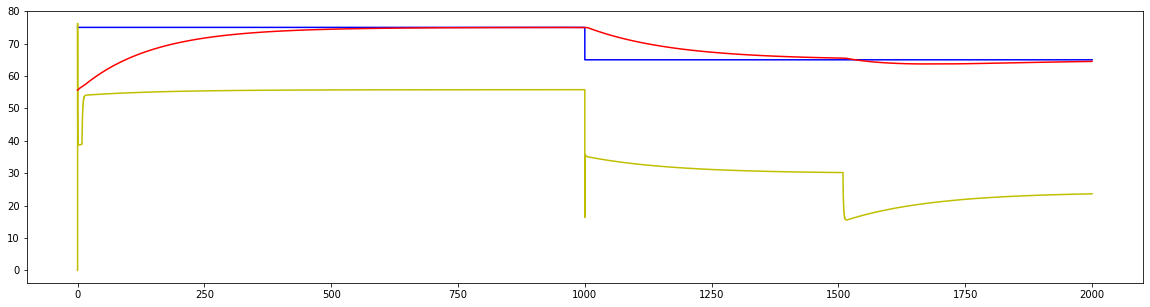

In [472]:
plt.figure(figsize = (20,11))
plt.subplot(2,1,1)


plt.step(t,SP,'b-',label='SP',where='post')
plt.step(t,MV,'y-',label='MV',where='post')
plt.step(t,PV,'r-',label='PV',where='post')

(25.0, 55.0)

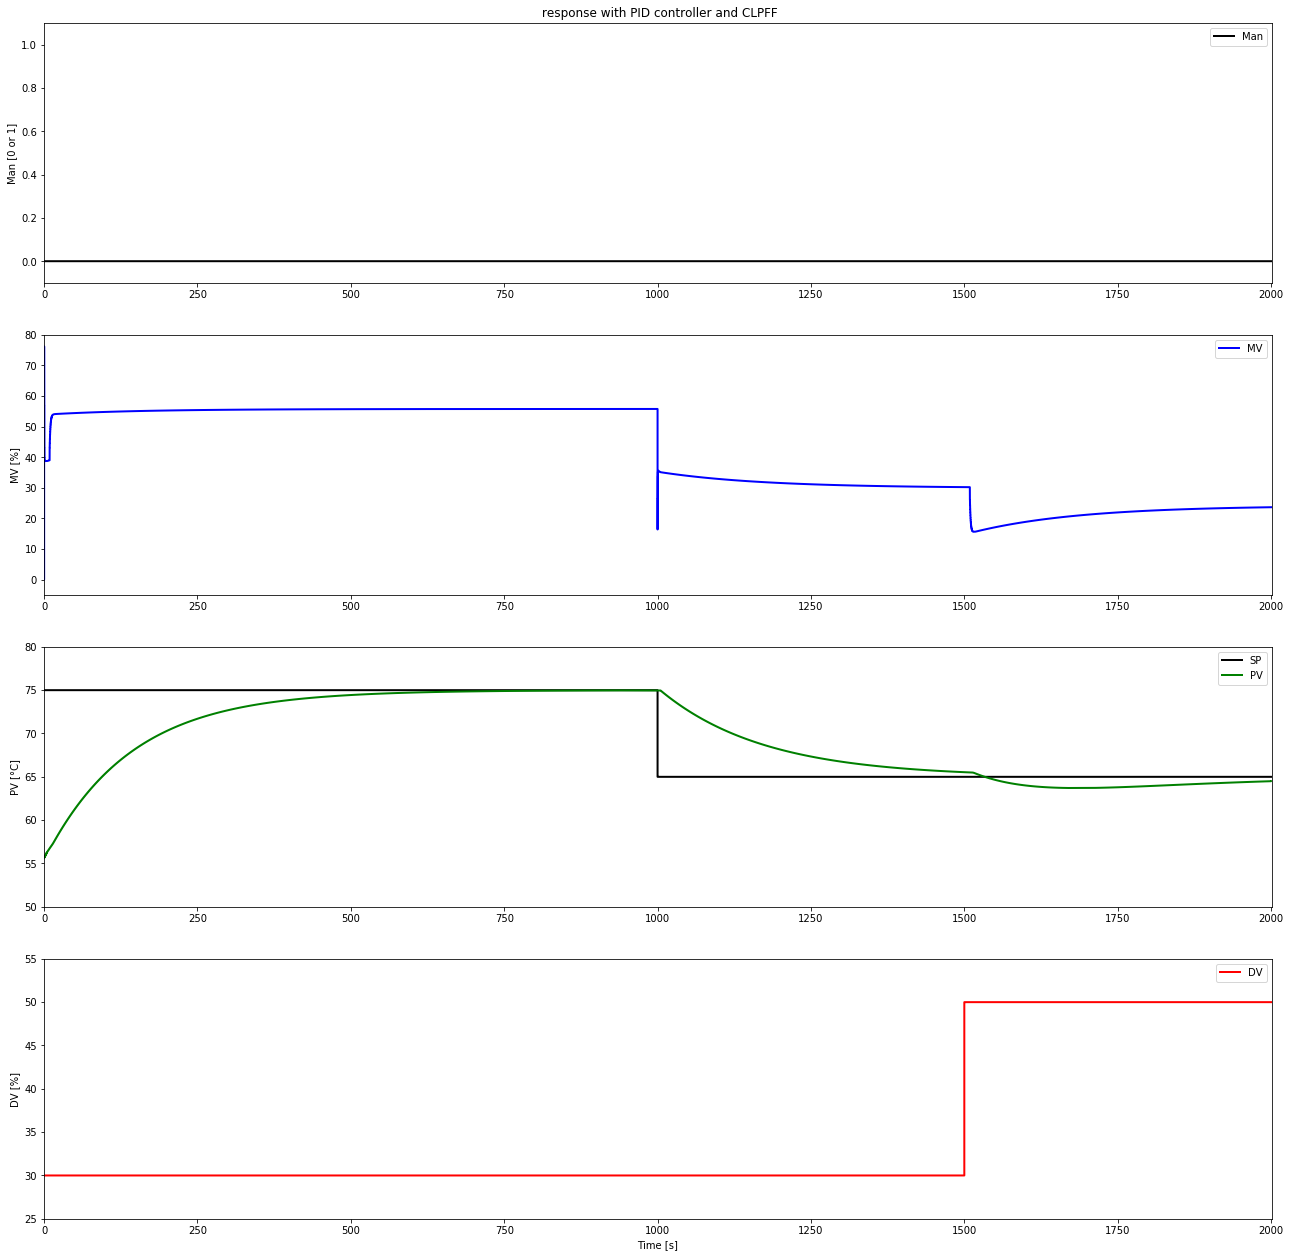

In [473]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1)
fig.set_figheight(22)
fig.set_figwidth(22)

l1, = ax1.step([0,t[-1]],[0,100],'k-',linewidth=2,label='Man',where='post')
ax1.set_ylabel('Man [0 or 1]')
ax1.set_title(' response with PID controller and ' + scenario)
ax1.legend(loc='best')

l2, = ax2.step([0,t[-1]],[0,100],'b-',linewidth=2,label='MV',where='post')
ax2.set_ylabel('MV [%]')
ax2.legend(loc='best')

l3, = ax3.step([0,t[-1]],[0,100],'k-',linewidth=2,label='SP',where='post')

l4, = ax3.step([0,t[-1]],[0,100],'g-',linewidth=2,label='PV',where='post')
ax3.set_ylabel('PV [°C]')
ax3.legend(loc='best')

l5, = ax4.step([0,t[-1]],[0,100],'r-',linewidth=2,label='DV',where='post')
ax4.set_xlabel('Time [s]')
ax4.set_ylabel('DV [%]')
ax4.legend(loc='best')

ManInt = [int(x) for x in Man]
l1.set_data(t,ManInt)
l2.set_data(t,MV)
l3.set_data(t,SP)
l4.set_data(t,PV)
l5.set_data(t,DV)

ax1.set_xlim(0,t[-1]+1)
ax2.set_xlim(0,t[-1]+1)
ax3.set_xlim(0,t[-1]+1)
ax4.set_xlim(0,t[-1]+1)

ax1.set_ylim(-0.1,1.1)
ax2.set_ylim(myRound(np.min(MV),5)-5, myRound(np.max(MV),5)+5)
ax3.set_ylim(myRound(np.min((np.min(PV),np.min(SP))),5)-5,myRound(np.max((np.max(PV),np.max(SP))),5)+5)
ax4.set_ylim(myRound(np.min(DV),5)-5,myRound(np.max(DV),5)+5)